# Visualizing tweets

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import json
import seaborn as sns
from wordcloud import WordCloud, STOPWORDS, ImageColorGenerator
from bs4 import BeautifulSoup
import re
import string
import spacy
import gensim
from textblob import TextBlob
from itertools import islice
from sklearn.manifold import TSNE

In [2]:
nlp = spacy.load('en')

In [3]:
with open("tweets_ww_6-5.txt", "r") as f:
    t_list =[]
    for line in f:
        tweet = json.loads(line)
        t_list.append(tweet)
        
with open("tweets.txt", "r") as f:
    t_list1 =[]
    for line in f:
        tweet = json.loads(line)
        t_list1.append(tweet)        

In [4]:
ww = pd.DataFrame(t_list)
ww1 = pd.DataFrame(t_list1)

ww_df = pd.concat([ww, ww1])
ww_df = ww_df.reset_index()

In [5]:
print(ww_df.shape)
ww_df[['favorite_count', 'filter_level', 'text', 'in_reply_to_user_id', 'source']].head()

(1501, 33)


,favorite_count,filter_level,text,in_reply_to_user_id,source
0,0,low,So… Can We Talk About That ‘Wonder Woman’ Fina...,None,"<a href=""https://dlvrit.com/"" rel=""nofollow"">d..."
1,0,low,So… Can We Talk About That ‘Wonder Woman’ Fina...,None,"<a href=""https://dlvrit.com/"" rel=""nofollow"">d..."
2,0,low,Fashion brands celebrate Wonder Woman - Fashio...,None,"<a href=""https://ifttt.com"" rel=""nofollow"">IFT..."
3,0,low,So… Can We Talk About That ‘Wonder Woman’ Fina...,None,"<a href=""https://dlvrit.com/"" rel=""nofollow"">d..."
4,0,low,Motivation Monday! Like millions I saw Wonder ...,None,"<a href=""http://instagram.com"" rel=""nofollow"">..."


In [6]:
def clean_text(text):
    
    # remove HTML
    text = BeautifulSoup(text, "html.parser").get_text()
    
    #removes url
    text = re.sub('https?:\/\/.*[\r\n]*', ' ', text, flags=re.MULTILINE)
       
    # removes numbers, symbols, nextline symbols 
    text = re.sub("[^a-zA-Z' ]"," ", text)   
    text = text.replace("\n", '').replace('  ', ' ').lower().strip('.')
    
    # removes some possessive, needs improvement
    text = re.sub("'s", "", text)
    text = nlp(text)
    
    # removes punctuation and pronouns, returns lemmatized word
    lex = nlp.vocab['not']
    lex.is_stop = False
    words=[]
    for word in text:
        if word.pos_ != 'PUNCT' and word.lemma_ != '-PRON-' and not word.is_space and not word.is_stop:
            words.append(word.lemma_)
                
    unigrams = [word for word in words if word not in ['t', 's', "v", "'s" "n't", "want", "film", "bullet", "vs", 
                                                       "physics", "bracelet", "diana", "youtube", "box", "office", 
                                                       "get", "gal", "gadot", "one", "dc", "superhero", "wonder", 
                                                       "woman", "movie", "go", "see", "wonderwoman", "watch", 
                                                       "watching"
                                                      ]
               ]
    
    return unigrams

In [7]:
clean_text(ww_df.text[53])

['think',
 'dial',
 'continue',
 'inch',
 'inch',
 'probably',
 'not',
 'quickly',
 'would',
 'like']

In [8]:
pd.set_option('display.width', 2000)
pd.set_option('display.max_columns', 500)

for i,item in islice(enumerate(ww_df['text'].str.findall('.*nearly.*')), 1500):
    if item != []:
        print(i, item)

334 ["Wonder Woman's most fantastic scene nearly didn't get made at all https://t.co/iYmFQClFhF https://t.co/VhFQueJLN8"]
363 ["Wonder Woman's most fantastic scene nearly didn't get made at all https://t.co/SrnxYd70oJ https://t.co/sCtziXLloI"]
1420 ["It's been nearly 12 hours since I last saw Wonder Woman and I am in withdrawal."]


Retweets are filtered out from the original streamfilter, but some popular topics are tweeted independently by many people as was the case for this item. Depending on the purpose of analysis some tweets may need to be filtered further.

In [9]:
tweet_list = ww_df['text'].apply(clean_text)

In [10]:
clean_text(ww_df['text'][17])

['fantastic', 'scene', 'nearly', 'not']

## Phrase modeling 

In [11]:
bigrams = gensim.models.phrases.Phraser(gensim.models.Phrases(tweet_list))
bigram_phrases = [bigrams[tweet] for tweet in tweet_list]
trigrams = gensim.models.phrases.Phraser(gensim.models.Phrases(bigram_phrases))
trigram_phrases = [trigrams[tweet] for tweet in bigram_phrases]

In [12]:
from collections import Counter

Counter([word for line in trigram_phrases for word in line]).most_common(20)

[('not', 130),
 ('be', 94),
 ('good', 80),
 ('like', 50),
 ('new', 41),
 ('love', 37),
 ('review', 36),
 ('great', 31),
 ('think', 31),
 ('today', 30),
 ('time', 30),
 ('man', 25),
 ('sequel_bring_america', 25),
 ('ne', 23),
 ('amazing', 23),
 ('thing', 23),
 ('win', 23),
 ('female', 23),
 ('record', 23),
 ('weekend', 22)]

In [13]:
from pylab import rcParams
rcParams.update({'font.size' : 14, 'legend.fontsize' : "small", 
                 "xtick.labelsize" : 14, "ytick.labelsize" : 14, 
                 "figure.figsize":(9, 6), "axes.titlesize" : 20,
                 "axes.labelsize" : 14, "lines.linewidth" : 3, 
                 "lines.markersize" : 10
})
sns.set_style("whitegrid")

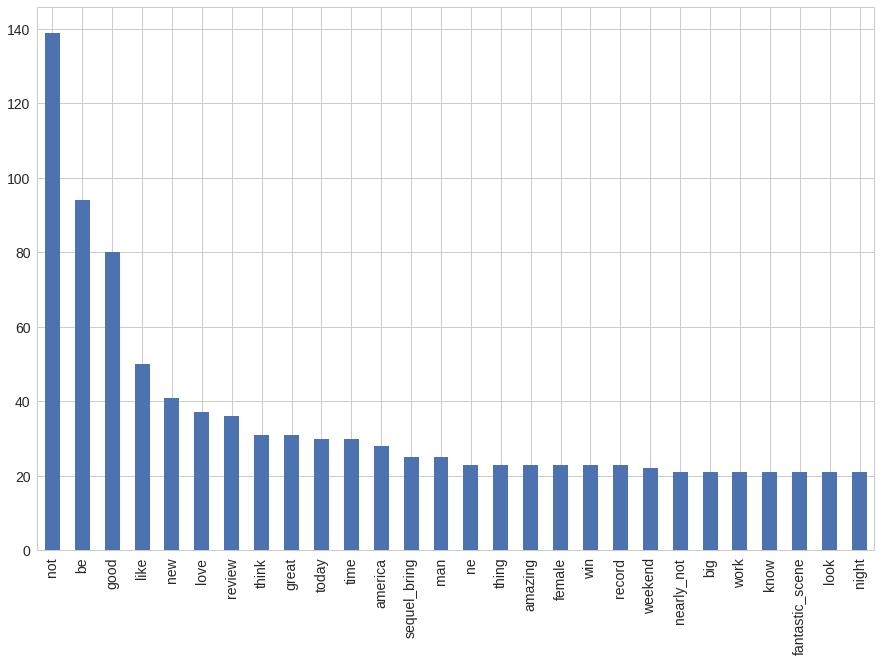

In [14]:
tweet_words = [word for tweet in bigram_phrases for word in tweet]
tweet_words = pd.Series(tweet_words)
tweet_words.value_counts()[tweet_words.value_counts() > 20].plot(kind = 'bar', figsize = (15, 10))
ax = plt.subplot()
for item in (ax.get_xticklabels() + ax.get_yticklabels()):
    item.set_fontsize(14)

plt.show()


In [15]:
text = ""
for word in tweet_words:
    text = text + " " + word

In [16]:
def sentiment(question):
    
    pol_sub = [TextBlob(question).sentiment.polarity, 
               TextBlob(question).sentiment.subjectivity]
    return pol_sub           

def unsplit(words):
    
    sent = str('')
    for word in words:
        if len(sent)==0:
            sent = word
        else:    
            sent = sent + ' ' + word
    return sent    

In [17]:
tweet_sentiment = tweet_list.apply(lambda x: sentiment(unsplit(x)))
print(tweet_sentiment[0:10])
tweet_list[0:10]

0       [0.0, 0.0]
1       [0.0, 0.0]
2       [0.0, 0.0]
3       [0.0, 0.0]
4       [1.0, 1.0]
5       [0.0, 1.0]
6      [-1.0, 1.0]
7       [0.0, 0.0]
8    [-0.625, 1.0]
9       [0.0, 0.0]
Name: text, dtype: object


0                                       [talk, finale]
1                                       [talk, finale]
2      [fashion, brand, celebrate, fashionunit, india]
3                                       [talk, finale]
4    [motivation, monday, like, million, weekend, i...
5                                              [giant]
6    [ain, docilely, make, sammich, yeah, cuz, evil...
7                                    [ne, immediately]
8              [imagine, mad, thor, are, loki, marvel]
9                                            [weekend]
Name: text, dtype: object

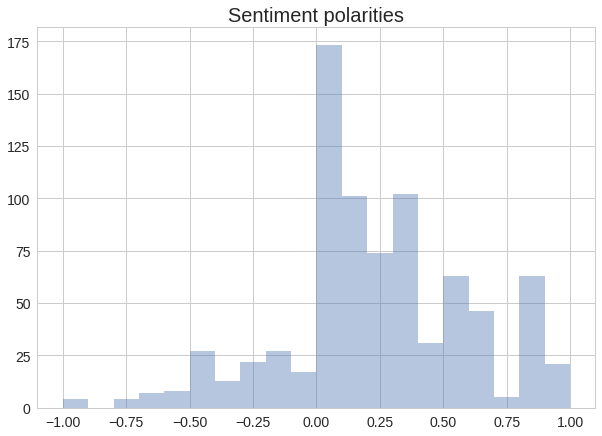

In [18]:
polarities = [pol[0] for pol in tweet_sentiment if pol[1] != 0]
plt.figure(figsize = (10,7))
sns.distplot(polarities, kde = False)
plt.title("Sentiment polarities")
plt.show()

In [19]:
print("mean: {:0.4f}".format(np.mean(polarities)))
print("median: {:0.4f}".format(np.median(polarities)))
print("99th percentile: {:0.4f}".format(np.percentile(polarities, 99)))
print('{} {:0.4f}'.format("std:", np.std(polarities)))

mean: 0.2341
median: 0.2083
99th percentile: 1.0000
std: 0.3672


## Hypothesis testing

In [20]:
# draw samples and calculate test statistic for boostrap testing, with replacement by default

def draw_sample(array, size = 1000):
    idx = np.random.choice(len(array), size)
    return [array[i] for i in idx]

def calc_stat(array, num_samples, func):
    sample_list = []
    for num in np.arange(num_samples):
        sample_list.append(func(draw_sample(array)))
    return sample_list


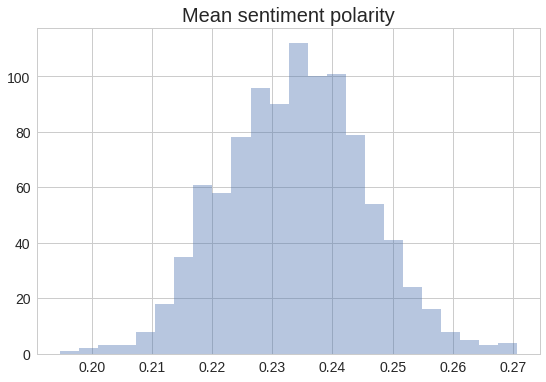

In [21]:
# test for how significant .241 is in sentiment value

#draw_sample(polarities)
pol_means = calc_stat(polarities, 1000, np.mean)
sns.distplot(pol_means, kde = False)

# prob the mean sentiment is greater than 0
np.sum(np.array(pol_means) > 0)/len(pol_means)
plt.title("Mean sentiment polarity")    
plt.show()

A potentially better way to conduct this experiment would have to collect sentiment before the showing of the movie and compare to sentiment after the movie premiered. However, this notebook provides the tools to do that. From the histogram above, all the bootstrapped sample means are greater than 0. Therefore, it's unlikely that the population sentiment is 0. Indicating that sentiment towards Wonder Woman was decidedly positive in the sample after the movie premier weekend. A larger tweet size should be considered before concluding that to be the case nationally by running the streamfilter for longer.

In [22]:
# ratio of positive to negative tweets

np.sum(pd.Series(polarities) > 0) / np.sum(pd.Series(polarities) < 0)

4.4031007751937983

Another way to get a sense of the tweet sentiment, roughly 4.65 times the number of positive to negative tweets the weekend after the movie. 

# POS tagging with spacy

In [23]:
parsed = nlp(ww_df['text'][10])
print(parsed)
print(parsed[2].lower_)
print(parsed[2].tag_)

Wonder Woman Sequel Will Bring Diana To America... https://t.co/s7gpbu3Ogk
sequel
NNP


In [24]:
def get_adj(text):
    a = []
    for word in nlp(text):
        if word.pos_ == "ADJ":
            a.append(word.lower_)
    return a        

In [25]:
bigram_sents = [' '.join(line) for line in tweet_list]
adj_list = [get_adj(sent) for sent in bigram_sents]

In [26]:
adj_words = [word for sent in adj_list for word in sent]
adj_words = [word for word in adj_words if not word in STOPWORDS]

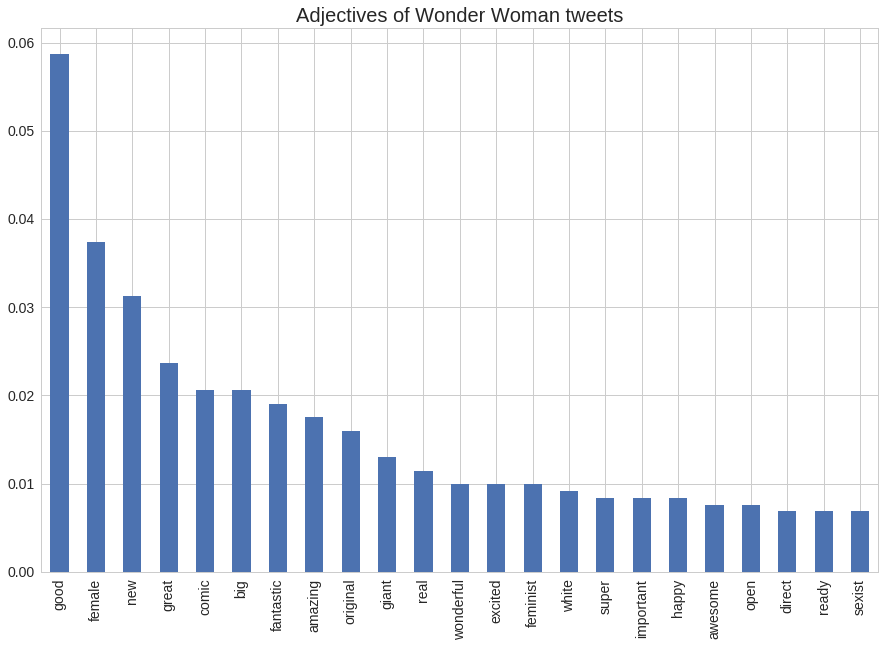

In [27]:
adj_words = pd.Series(adj_words)
adj_words.value_counts(normalize=True)[adj_words.value_counts() > 8].plot(kind = 'bar', figsize = (15, 10))
plt.title("Adjectives of Wonder Woman tweets")

plt.show()

## Wordcloud of tweet adjectives

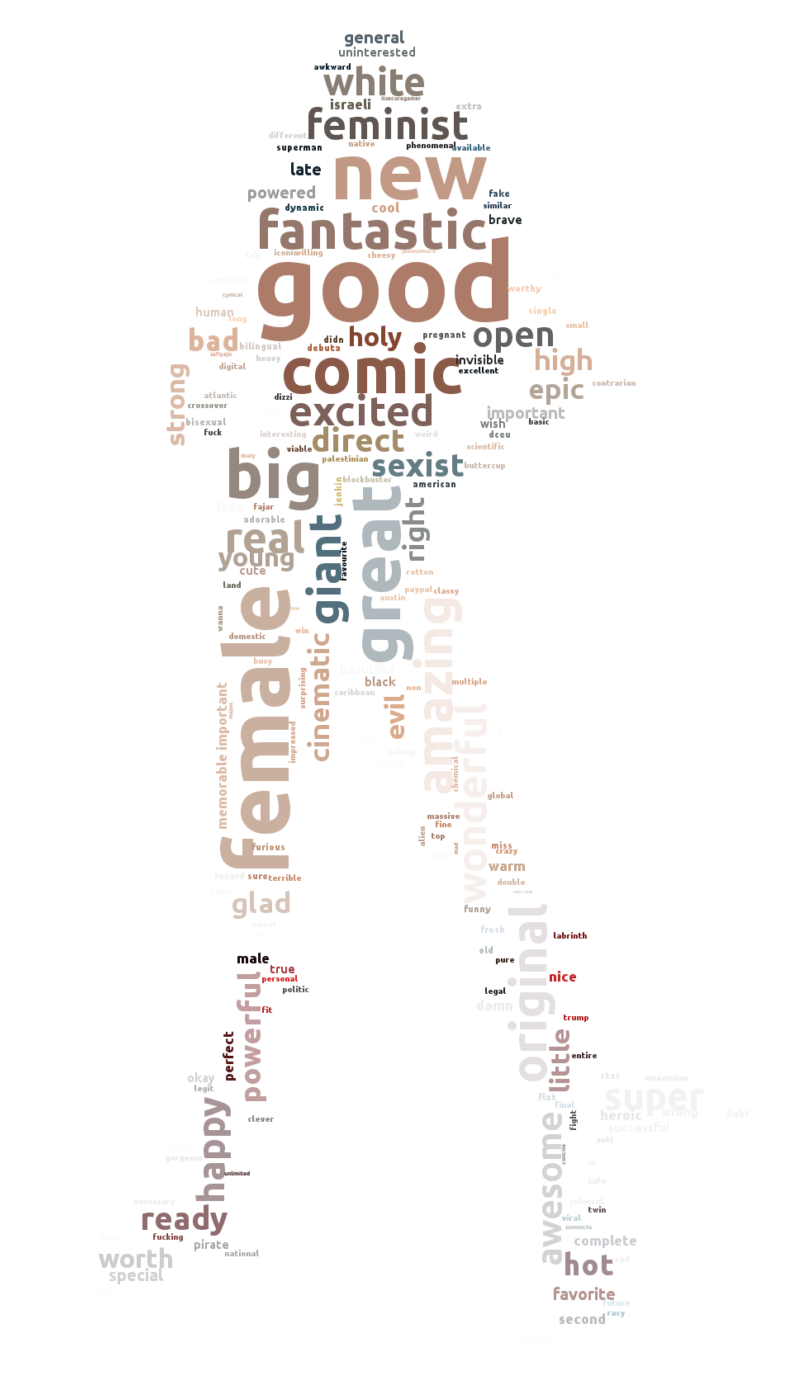

In [28]:
from scipy.misc import imread
from PIL import Image

font = '/usr/share/fonts/truetype/ubuntu-font-family/Ubuntu-B.ttf'
ww_img = imread("./wonder_woman2.jpg")
coloring = np.array(Image.open("./wonder_woman2.jpg"))
image_colors = ImageColorGenerator(coloring)
    
wc = WordCloud(font_path = font, mask= ww_img, max_font_size=80, min_font_size=2, 
                width=1800, height=2000, background_color = "white", 
                stopwords = STOPWORDS, max_words=200, scale = 2.5)

wc.generate(' '.join(adj_words))
plt.figure(figsize = (25, 25))
plt.imshow(wc.recolor(color_func = image_colors), interpolation="bilinear")
plt.axis("off")
plt.show()

## Word vectors

This probably needs a bigger corpus to be useful, but the contextual similarity is interesting to see using most_similar, followed by a TSNE transformation of the vectors and getting a graphical representation of the word vectors in 2 dimensions.

In [29]:
w2vec = gensim.models.Word2Vec(bigram_phrases)

In [30]:
w2vec.most_similar(positive=['fantastic_scene'], topn=3)

[('cosplay', 0.3007616698741913),
 ('add_video', 0.2753840982913971),
 ('didn', 0.24201256036758423)]

In [31]:
vocab = list(w2vec.wv.vocab)
X = w2vec[w2vec.wv.vocab]

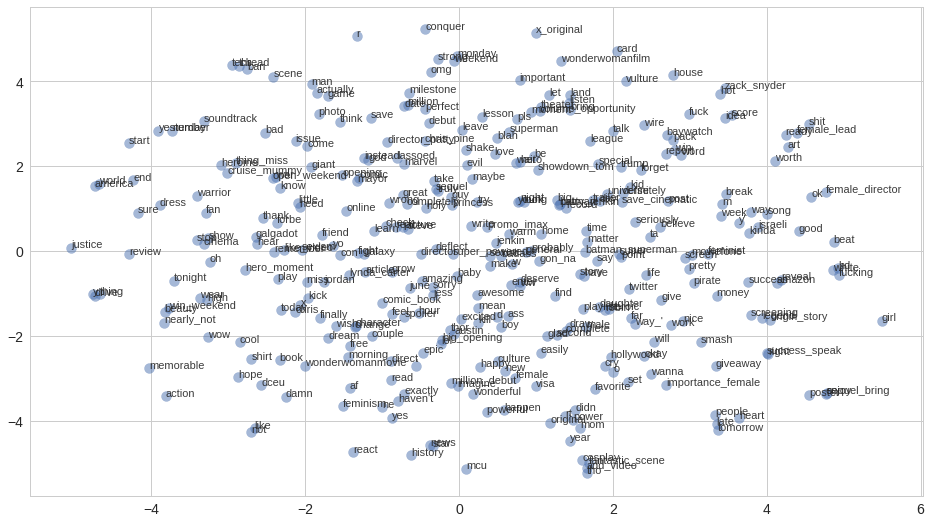

In [33]:
model = TSNE(learning_rate=100)
tsne_features = model.fit_transform(X)
xs = tsne_features[:,0]
ys = tsne_features[:,1]
plt.figure(figsize = (16,9))

# Scatter plot
plt.scatter(xs, ys, alpha=0.5)

# Annotate the points
for x, y, word in zip(xs, ys, vocab):
    plt.annotate(word, (x, y), fontsize=11, alpha=0.9)
plt.show()